In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [147]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [148]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)


('2017-08-23',)


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_year = dt.date(2017,8,23) - dt.timedelta(days=365)
print(last_year)   

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.head()


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [16]:
 #Sort the dataframe by date
rain_df.sort_values(by=['date'])
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


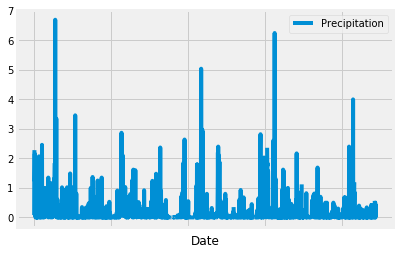

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.legend(["Precipitation"])


# Exploratory Climate Analysis

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017,8,23) - dt.timedelta(days=365)
print(last_year)

# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.head()
# Sort the dataframe by date
rain_df.sort_values(by=['date'])
rain_df.head()
# Use Pandas Plotting with Matplotlib to plot the data


('2017-08-23',)
2016-08-23


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print(locations)


9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?

active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()
active = active_station[0][0]    
print("The most active stations: ",active,"with",active_station[0][1],"weather observations.")
print()

# List the stations and the counts in descending order.
for station, count in active_station:
    print(station,":",count)




The most active stations:  USC00519281 with 2772 weather observations.

USC00519281 : 2772
USC00519397 : 2724
USC00513117 : 2709
USC00519523 : 2669
USC00516128 : 2612
USC00514830 : 2202
USC00511918 : 1979
USC00517948 : 1372
USC00518838 : 511


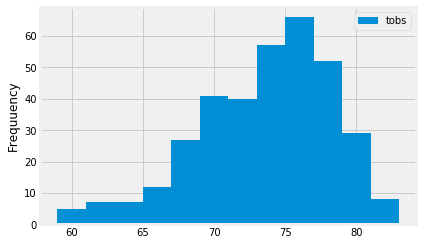

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == active).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

#print(temperature)
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.legend(["tobs"])
plt.ylabel("Frequuency")
plt.show()


In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))




[(62.0, 69.57142857142857, 74.0)]


In [30]:
arrive = dt.date(2012, 2, 28)
leave = dt.date(2012, 3, 5)
last_year = dt.timedelta(days=365)
avg_temp_lst_year = (calc_temps((arrive-last_year), (leave-last_year)))
print(avg_temp_lst_year)


[(61.0, 70.08928571428571, 75.0)]


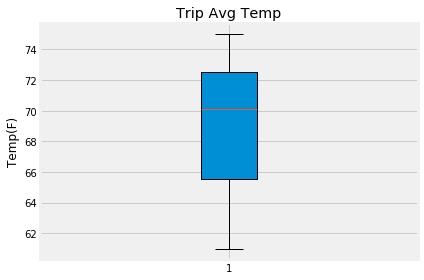

In [32]:
f, ax = plt.subplots()
x = range(len(avg_temp_lst_year))
ax.boxplot(avg_temp_lst_year, patch_artist=True)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp(F)')
f.tight_layout()
plt.show()
